# 💧 Water Potability Prediction - Model Training Notebook

This notebook builds a machine learning pipeline to predict whether a given water sample is potable or not using the cleaned water quality dataset. It includes:
- Data preprocessing
- Handling class imbalance with SMOTE
- Scaling
- XGBoost modeling with calibration
- Evaluation and model export

Dataset: `data/water_potability_cleaned.csv`


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Step 1: Load the cleaned dataset
df = pd.read_csv("../data/water_potability_cleaned.csv")
df.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


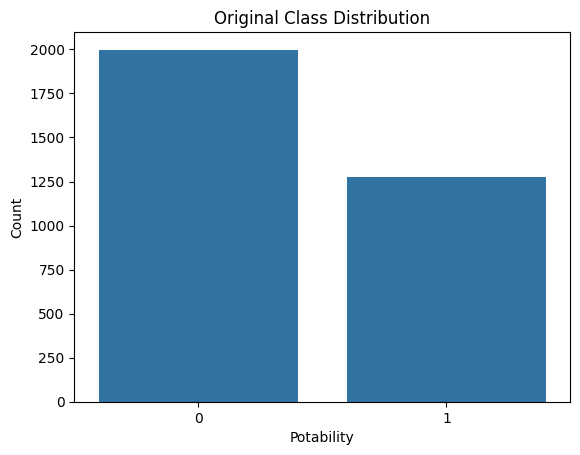

In [3]:
sns.countplot(x='Potability', data=df)
plt.title("Original Class Distribution")
plt.xlabel("Potability")
plt.ylabel("Count")
plt.show()


In [4]:
# Step 2: Feature-target split
X = df.drop("Potability", axis=1)
y = df["Potability"]


In [5]:
# Step 3: Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)


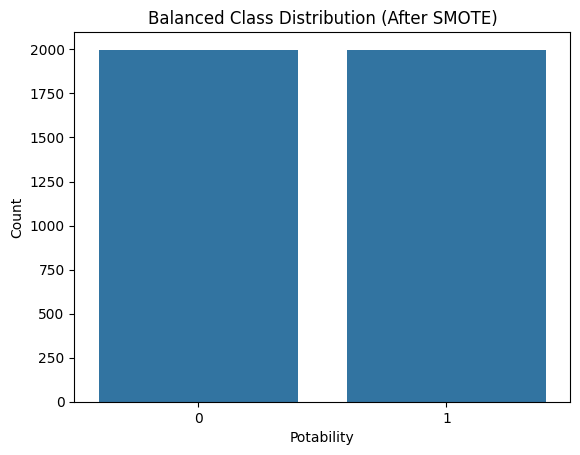

In [6]:
sns.countplot(x=y_bal)
plt.title("Balanced Class Distribution (After SMOTE)")
plt.xlabel("Potability")
plt.ylabel("Count")
plt.show()


In [7]:
# Step 4: Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal)


In [8]:
# Step 5: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_bal, test_size=0.2, random_state=42)


In [9]:
# Step 6: Build and train the calibrated XGBoost classifier
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

calibrated_model = CalibratedClassifierCV(xgb, cv=5)
calibrated_model.fit(X_train, y_train)


CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=4,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None, ...))

In [10]:
# Step 7: Evaluate the model
y_pred = calibrated_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[260 134]
 [147 259]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.66      0.65       394
           1       0.66      0.64      0.65       406

    accuracy                           0.65       800
   macro avg       0.65      0.65      0.65       800
weighted avg       0.65      0.65      0.65       800



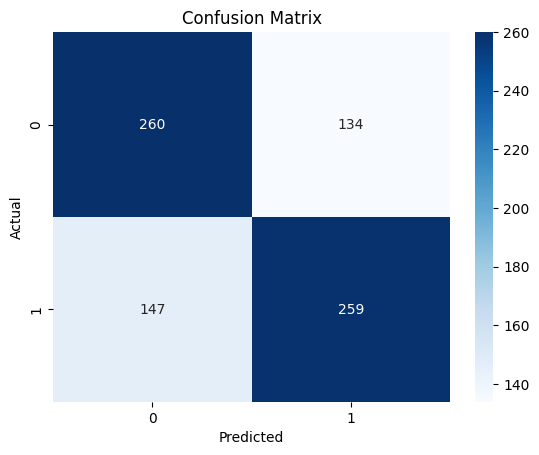

In [11]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


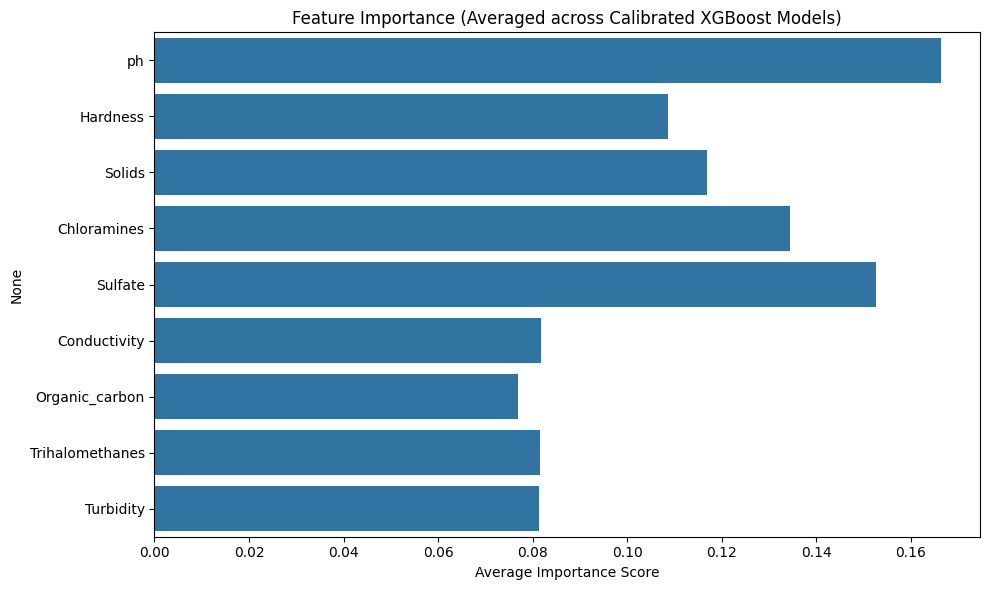

In [12]:
# Extract feature importances from each XGBoost estimator
importances_list = [cal.estimator.feature_importances_ for cal in calibrated_model.calibrated_classifiers_]

# Average them across all calibrated folds
avg_importances = np.mean(importances_list, axis=0)

# Plot
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_importances, y=features)
plt.title("Feature Importance (Averaged across Calibrated XGBoost Models)")
plt.xlabel("Average Importance Score")
plt.tight_layout()
plt.show()


In [13]:
# Step 8: Save model and scaler to disk
os.makedirs("../models", exist_ok=True)
joblib.dump(calibrated_model, "../models/water_potability_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("✅ Final XGBoost model and scaler saved to 'models/' folder.")


✅ Final XGBoost model and scaler saved to 'models/' folder.
